<a href="https://colab.research.google.com/github/lqiang67/rectified-flow/blob/main/examples/editing_flux_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lqiang67/rectified-flow.git
%cd rectified-flow/

In [ ]:
# Optional: Login to Hugging Face if you haven't downloaded the checkpoint yet.
# Make sure you select "Read access to contents of all public gated repos you can access" when creating the token
from huggingface_hub import login
login(token="YOUR_HUGGINGFACE_TOKEN") # Fill your huggingface token here

# Optional: Specify custom cache directories (modify paths as needed)
import os
os.environ['HF_HOME'] = './'
os.environ['HF_HUB_CACHE'] = './'
os.environ['HF_DATASETS_CACHE'] = './'

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import sys
import os

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms
from IPython.display import clear_output

DTYPE = torch.bfloat16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=DTYPE)
pipe.to(device)
print(f"Loaded pipeline to device {device}")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pipeline to device cuda:0


In [2]:
from rectified_flow.models.flux_dev import FluxWrapper
from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import set_seed

set_seed(0)

height = 1024
width = 1024

flux_model = FluxWrapper(
    pipeline=pipe,
    height=height,
    width=width,
    dtype=DTYPE,
    device=device,
)

rectified_flow = RectifiedFlow(
    data_shape=flux_model.dit_latent_shape,
    velocity_field=flux_model,
    interp="straight",
    device=device,
	dtype=DTYPE,
)

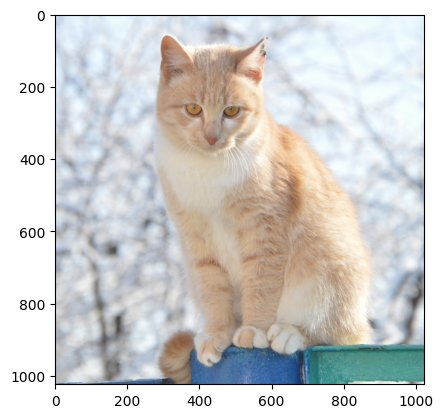

In [3]:
img = Image.open("../assets/editing_cat.png")

train_transforms = transforms.Compose(
            [
                transforms.Resize(1024, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(1024),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

img = train_transforms(img).unsqueeze(0).to("cuda").to(DTYPE)

img_latent = flux_model.encode(img)
img_rec = flux_model.decode(img_latent)

plt.imshow(img_rec)

# A simple noisy interpolation editing

Given the image $X_1$, we first add noise to the image using the equation $X_t = X_1 \cdot t + (1 - t) \cdot \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$ represents the mixed noise. We then apply the Euler sampler starting from $X_t$ with the editing target prompt to obtain the result.

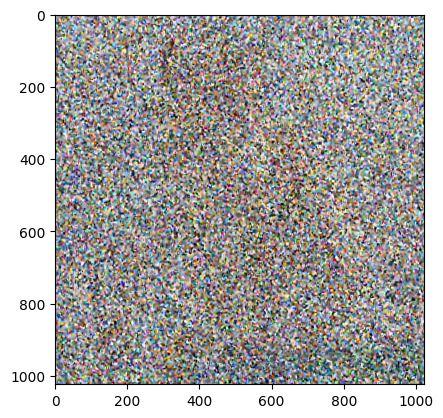

In [4]:
noise = rectified_flow.sample_source_distribution(1)

noisy_time = 0.12
t = torch.full((1,), noisy_time)
t = rectified_flow.match_dim_with_data(t, img_latent.shape, expand_dim=True)

x_t = t * img_latent.clone() + (1 - t) * noise

time_grid = torch.linspace(noisy_time, 1, 50).tolist()

x_t_rec = flux_model.decode(x_t)
plt.imshow(x_t_rec)

For simple editing tasks, such as turning a cat into a tiger, this straightforward renoising method works effectively.

Prompt "a photo of a sitting tiger" encoded.


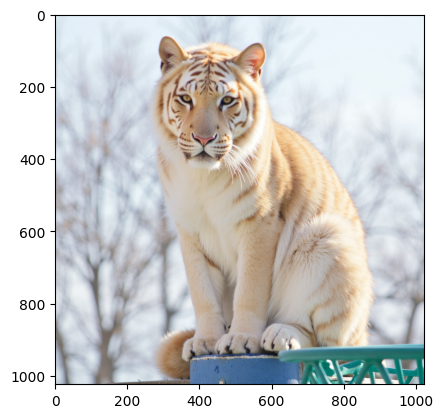

In [5]:
from rectified_flow.samplers import EulerSampler

sampler = EulerSampler(
    rectified_flow=rectified_flow,
    time_grid=time_grid,
)

prompt = "a photo of a sitting tiger"

x_1 = sampler.sample_loop(x_0=x_t, prompt=prompt, guidance_scale=3.5).trajectories[-1]

x_1_rec = flux_model.decode(x_1)
plt.imshow(x_1_rec)

However, for more "complex" or larger-scale edits, directly adding noise and then denoising becomes challenging.

Prompt "a photo of a reflective silver cat statue, with a smooth glossy surface" encoded.


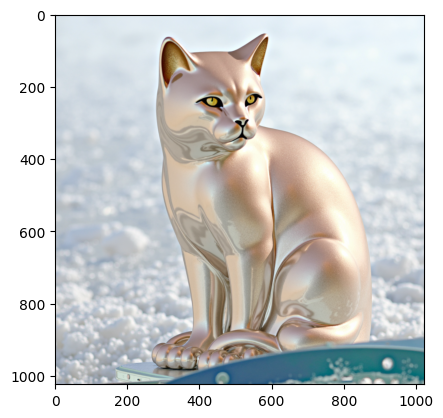

In [6]:
prompt = "a photo of a reflective silver cat statue, with a smooth glossy surface"

# Try different noise time, can't achieve ideal result
noisy_time = 0.1
t = torch.full((1,), noisy_time)
t = rectified_flow.match_dim_with_data(t, x_1.shape, expand_dim=True)
x_t = t * img_latent.clone() + (1 - t) * noise
time_grid = torch.linspace(noisy_time, 1, 50).tolist()

x_1 = sampler.sample_loop(x_0=x_t, time_grid=time_grid, prompt=prompt, guidance_scale=3.5).trajectories[-1]

x_1_rec = flux_model.decode(x_1)
plt.imshow(x_1_rec)

# A more advanced soft interpolation editing

In [7]:
from rectified_flow.samplers import EulerSampler

class EditingVelocityFiled(torch.nn.Module):
    def __init__(self, velocity_model, analytic_velocity, start_t, end_t, eta_base, eta_trend, alpha=1.):
        super().__init__()
        self.start_t = start_t
        self.end_t = end_t
        self.eta_base = eta_base
        self.eta_trend = eta_trend
        self.alpha = alpha
        self.velocity_model = velocity_model
        self.analytic_velocity = analytic_velocity
        
    @staticmethod
    def get_eta_value(t, start_t, end_t, eta, eta_trend, alpha):
        assert 0 <= start_t < end_t <= 1.0, "start_t and end_t must be in [0, 1] range, and start_t < end_t"
        assert 0 <= eta <= 1.0, "eta must be in [0, 1] range"
        if t < start_t or t > end_t:
            return torch.tensor(0.0, device=t.device, dtype=t.dtype)
        
        alpha = torch.tensor(alpha, device=t.device, dtype=t.dtype)
        tau = (t - start_t) / (end_t - start_t)
        if eta_trend == 'constant':
            return eta
        elif eta_trend == 'linear_decrease':
            return eta * (1 - tau)
        elif eta_trend == 'exponential_decrease':
            if abs(alpha) < 1e-5:
                return eta * (1 - tau)
            else:
                numerator = torch.exp(alpha * tau) - 1
                denominator = torch.exp(alpha) - 1
                return eta * (1 - (numerator / denominator))
        else:
            raise NotImplementedError(f"Unsupported eta_trend: {eta_trend}")
        
    def forward(self, x_t, t, **kwargs):
        original_velocity = self.velocity_model(x_t, t, **kwargs)
        target_velocity = self.analytic_velocity(x_t, t)
        
        eta = self.get_eta_value(t, self.start_t, self.end_t, self.eta_base, self.eta_trend, self.alpha)

        print(f"Current time: {t.item():.4f}, {eta.item():.4f} * target velocity, {1 - eta.item():.4f} * original velocity")
        
        return eta * target_velocity + (1 - eta) * original_velocity

In [8]:
from rectified_flow.models.gauss_analytic import AnalyticGaussianVelocity

analytic_velocity = AnalyticGaussianVelocity(dataset=img_latent, interp=rectified_flow.interp)

editing_velocity_field = EditingVelocityFiled(
    velocity_model=flux_model,
    analytic_velocity=analytic_velocity,
    start_t=0.,
    end_t=0.25,
    eta_base=0.93,
    eta_trend='exponential_decrease',
    alpha=2.,
)

editing_rectified_flow = RectifiedFlow(
    data_shape=flux_model.dit_latent_shape,
    velocity_field=editing_velocity_field,
    interp="straight",
    device=device,
	dtype=DTYPE,
)

Prompt "a photo of a sitting tiger" encoded.
Current time: 0.0000, 0.9297 * target velocity, 0.0703 * original velocity
Current time: 0.0116, 0.9141 * target velocity, 0.0859 * original velocity
Current time: 0.0238, 0.9023 * target velocity, 0.0977 * original velocity
Current time: 0.0366, 0.8789 * target velocity, 0.1211 * original velocity
Current time: 0.0500, 0.8555 * target velocity, 0.1445 * original velocity
Current time: 0.0645, 0.8320 * target velocity, 0.1680 * original velocity
Current time: 0.0796, 0.8008 * target velocity, 0.1992 * original velocity
Current time: 0.0957, 0.7617 * target velocity, 0.2383 * original velocity
Current time: 0.1123, 0.7188 * target velocity, 0.2812 * original velocity
Current time: 0.1309, 0.6602 * target velocity, 0.3398 * original velocity
Current time: 0.1494, 0.5977 * target velocity, 0.4023 * original velocity
Current time: 0.1699, 0.5078 * target velocity, 0.4922 * original velocity
Current time: 0.1924, 0.3965 * target velocity, 0.6035 

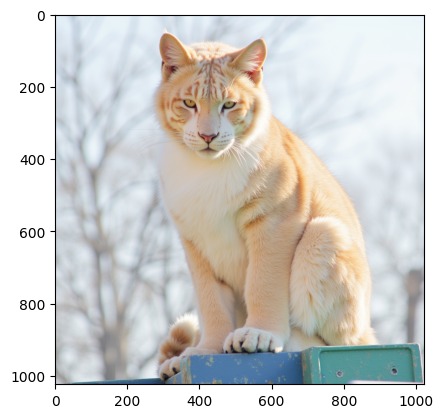

In [9]:
from rectified_flow.samplers import EulerSampler

time_grid = flux_model.prepare_time_grid(28)

sampler = EulerSampler(
    rectified_flow=editing_rectified_flow,
	time_grid=time_grid,
    num_samples=1,
)

prompt = "a photo of a sitting tiger"

x_1 = sampler.sample_loop(seed=0, prompt=prompt, guidance_scale=3.5).trajectories[-1]

x_1_rec = flux_model.decode(x_1)
plt.imshow(x_1_rec)

Current time: 0.0000, 0.9297 * target velocity, 0.0703 * original velocity
Current time: 0.0064, 0.9219 * target velocity, 0.0781 * original velocity
Current time: 0.0130, 0.9141 * target velocity, 0.0859 * original velocity
Current time: 0.0198, 0.9062 * target velocity, 0.0938 * original velocity
Current time: 0.0269, 0.8945 * target velocity, 0.1055 * original velocity
Current time: 0.0339, 0.8828 * target velocity, 0.1172 * original velocity
Current time: 0.0415, 0.8711 * target velocity, 0.1289 * original velocity
Current time: 0.0491, 0.8555 * target velocity, 0.1445 * original velocity
Current time: 0.0569, 0.8477 * target velocity, 0.1523 * original velocity
Current time: 0.0649, 0.8320 * target velocity, 0.1680 * original velocity
Current time: 0.0732, 0.8125 * target velocity, 0.1875 * original velocity
Current time: 0.0820, 0.7969 * target velocity, 0.2031 * original velocity
Current time: 0.0908, 0.7734 * target velocity, 0.2266 * original velocity
Current time: 0.1001, 0.7

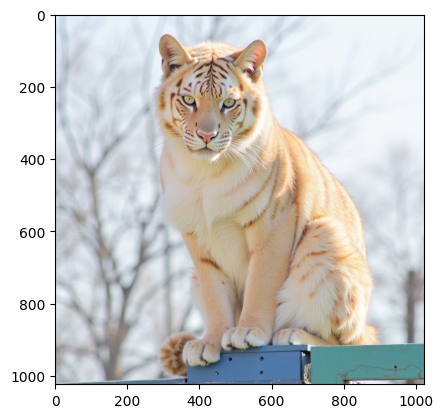

In [10]:
from rectified_flow.samplers import SDESampler

time_grid = flux_model.prepare_time_grid(50)

stochastic_sampler = SDESampler(
    rectified_flow=editing_rectified_flow,
	time_grid=time_grid,
    num_samples=1,
    noise_scale=2.0,
)

prompt = "a photo of a sitting tiger"

x_1 = stochastic_sampler.sample_loop(seed=0, prompt=prompt, guidance_scale=3.5).trajectories[-1]

x_1_rec = flux_model.decode(x_1)
plt.imshow(x_1_rec)

Prompt "a sitting cat statue, with a reflective silver surface" encoded.
Current time: 0.0000, 0.8984 * target velocity, 0.1016 * original velocity
Current time: 0.0064, 0.8906 * target velocity, 0.1094 * original velocity
Current time: 0.0130, 0.8711 * target velocity, 0.1289 * original velocity
Current time: 0.0198, 0.8594 * target velocity, 0.1406 * original velocity
Current time: 0.0269, 0.8398 * target velocity, 0.1602 * original velocity
Current time: 0.0339, 0.8203 * target velocity, 0.1797 * original velocity
Current time: 0.0415, 0.7930 * target velocity, 0.2070 * original velocity
Current time: 0.0491, 0.7695 * target velocity, 0.2305 * original velocity
Current time: 0.0569, 0.7383 * target velocity, 0.2617 * original velocity
Current time: 0.0649, 0.7070 * target velocity, 0.2930 * original velocity
Current time: 0.0732, 0.6680 * target velocity, 0.3320 * original velocity
Current time: 0.0820, 0.6172 * target velocity, 0.3828 * original velocity
Current time: 0.0908, 0.570

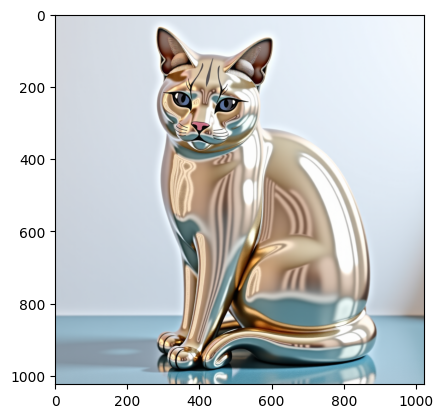

In [11]:
time_grid = flux_model.prepare_time_grid(50)

editing_velocity_field.end_t = 0.15
editing_velocity_field.eta_base = 0.9

stochastic_sampler = SDESampler(
    rectified_flow=editing_rectified_flow,
	time_grid=time_grid,
    num_samples=1,
    noise_scale=10.0,
)

prompt = "a sitting cat statue, with a reflective silver surface"

x_1 = stochastic_sampler.sample_loop(seed=0, prompt=prompt, guidance_scale=10.0).trajectories[-1]

x_1_rec = flux_model.decode(x_1)
plt.imshow(x_1_rec)